# Facenet-pytorch viz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
import sklearn as sk
import scipy as sc
import seaborn as sns
import seaborn_image as isns

In [2]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [3]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [4]:
#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True)

In [5]:
#import itables
#from itables import show

In [6]:
from collections import namedtuple
import itertools
from itertools import product

In [7]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [8]:
import PIL as pil
from PIL import Image, ImageDraw

In [9]:
import geopy as gp

In [10]:
#import papermill as pm

In [11]:
import math

In [12]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [13]:
import os

In [14]:
import functools

In [15]:
import facenet_pytorch

## Load our model

In [16]:
import torch
import torchvision
from einops import rearrange, reduce, repeat

In [17]:
torch.cuda.is_available()

True

In [18]:
device = torch.device('cuda')

In [19]:
model = facenet_pytorch.InceptionResnetV1(pretrained='vggface2').eval()

In [20]:
model = model.to(device)

## Utility functions

In [21]:
def whiten_image(x):
    return (x-x.mean(axis=(0,1), keepdims=True))/x.std(axis=(0,1), keepdims=True)

In [22]:
df = pd.read_pickle('df_intermediate_embeds.pickle')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Columns: 521 entries, index to 511
dtypes: float32(512), int64(5), object(4)
memory usage: 138.8+ KB


In [24]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [25]:
channels = [bands.index(i) for i in ['wr', 'wg', 'wb', *(('nir',)*3)]]

In [26]:
def crop_center(img,cropx,cropy):
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

## Non-finetuned facenet outputs

In [28]:
df['whitened'] = df['crop'].progress_apply(lambda x: torchvision.transforms.functional.resize(
    torch.Tensor(rearrange(whiten_image(crop_center(x, 64, 64)[:,:,channels[:3]]), '(b h) w c -> b c h w', b=1)), (160, 160), antialias=True))

  0%|          | 0/67 [00:00<?, ?it/s]

In [29]:
with torch.no_grad():
    df['embeds'] = df['whitened'].progress_apply(lambda x: model(x.to(device)).cpu())

  0%|          | 0/67 [00:00<?, ?it/s]

In [30]:
embeds = df['embeds'].progress_apply(lambda x: pd.Series(x.detach().flatten()))

  0%|          | 0/67 [00:00<?, ?it/s]

In [31]:
df = pd.concat((df[[i for i in df.columns if i != 'embeds']], embeds), axis=1)

In [32]:
df.to_pickle('df_intermediate_embeds.pickle')

In [33]:
df_nv = df.drop(['crop', 'whitened'], axis=1)

In [34]:
X = df_nv.iloc[:,7:]

In [35]:
y = df_nv['name']

## UMAP our previous outputs

In [36]:
from umap import UMAP

E:\miniconda3\envs\cuda_env\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\miniconda3\envs\cuda_env\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\miniconda3\envs\cuda_env\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopyth

In [37]:
train = df_nv[df_nv['src'] == '10May2021']
test = df_nv[df_nv['src'] == '18Dec2020']

In [38]:
X_train, X_test = train.iloc[:,7:], test.iloc[:,7:]
y_train, y_test = train['name'], test['name']

In [39]:
reducer = UMAP(n_components=2, n_neighbors=5, min_dist=0.1, metric='euclidean')

In [40]:
reducer.fit(X)
X_train_trans = reducer.transform(X_train)
X_test_trans = reducer.transform(X_test)

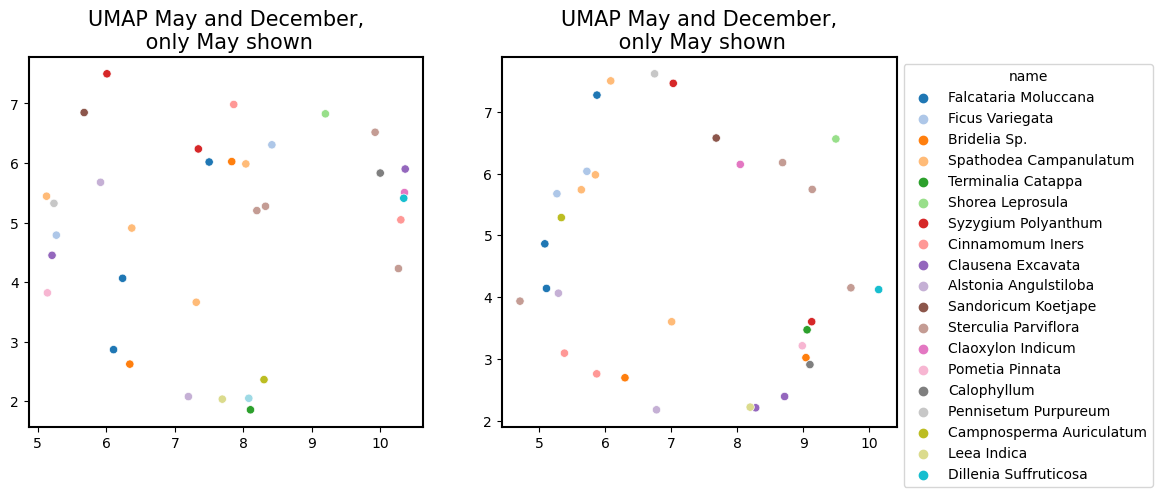

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.scatterplot(x=X_train_trans[:,0],
                y=X_train_trans[:,1],
                hue=y_train,
                palette='tab20',
                legend=False,
                ax=ax[0])
ax[0].set_title("UMAP May and December,\n only May shown")
sns.scatterplot(x=X_test_trans[:,0],
                y=X_test_trans[:,1],
                hue=y_test,
                palette='tab20',
                ax=ax[1])
ax[1].set_title("UMAP May and December,\n only May shown")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))

## Compare to a PCA

In [42]:
from sklearn.decomposition import PCA

In [43]:
reducer = PCA(n_components=2)

In [44]:
X_trans = reducer.fit_transform(X)

In [45]:
reducer.fit(X)
X_train_trans = reducer.transform(X_train)
X_test_trans = reducer.transform(X_test)

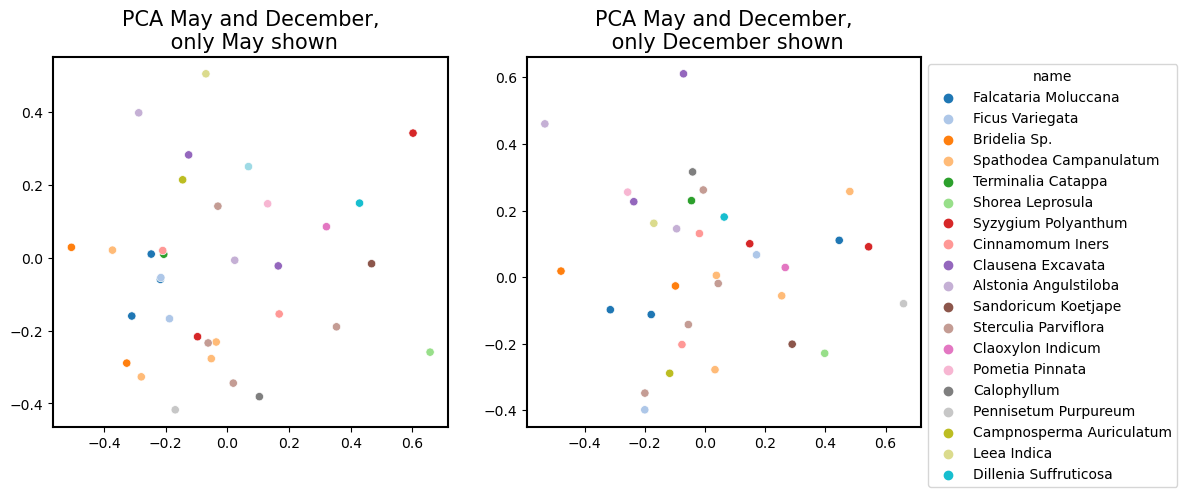

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.scatterplot(x=X_train_trans[:,0],
                y=X_train_trans[:,1],
                hue=y_train,
                palette='tab20',
                legend=False,
                ax=ax[0])
ax[0].set_title("PCA May and December,\n only May shown")
sns.scatterplot(x=X_test_trans[:,0],
                y=X_test_trans[:,1],
                hue=y_test,
                palette='tab20',
                ax=ax[1])
ax[1].set_title("PCA May and December,\n only December shown")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))

## Compare to an LDA

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [48]:
reducer = LinearDiscriminantAnalysis(n_components=2)

In [49]:
reducer.fit(X_train, y_train)
X_train_trans = reducer.transform(X_train)
X_test_trans = reducer.transform(X_test)

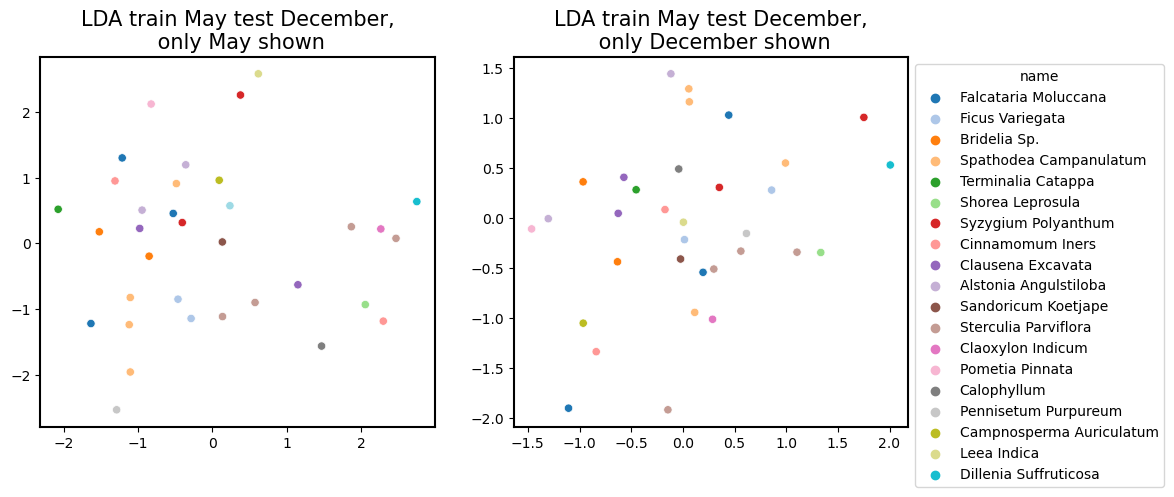

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.scatterplot(x=X_train_trans[:,0],
                y=X_train_trans[:,1],
                hue=y_train,
                palette='tab20',
                legend=False,
                ax=ax[0])
ax[0].set_title("LDA train May test December,\n only May shown")
sns.scatterplot(x=X_test_trans[:,0],
                y=X_test_trans[:,1],
                hue=y_test,
                palette='tab20',
                ax=ax[1])
ax[1].set_title("LDA train May test December,\n only December shown")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))